# Time Series Prediction

In [8]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import EarlyStopping
import json
import random
from keras import backend as K

## Read in Data

In [9]:
# Read in feature data
with open('../../../../data/feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None
for i in database:
    # Filter emission data
    if (database[i]['sector'] != 'target_values' and 
        database[i]['sector'] != 'greenhouse_emissions'):
        new_data = pd.read_json(database[i]['data'])
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        print(f"Feature not used: {i}")
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(f"Shape input features: {feature_data.shape}")
#feature_data.head()

Feature not used: E_Mio.tonnes_CO2
Feature not used: M_Mio.tonnes_CO2
Feature not used: ECO_Mio.tonnes_CO2
Feature not used: Total_CO2_Emission
Shape input features: (111, 40)


In [10]:
# Read in emission data
emission_data = pd.read_csv('../../../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')
# Take only the emissions on which we have indicators
emission_data = emission_data[len(emission_data)-feature_data.shape[0]:]
print(f"Shape output data: {emission_data.shape}")

Shape output data: (111,)


In [11]:
# Convert an array of values into a dataset matrix
def sliding_window(input, output, look_back=1, horizon=1, shuffle=False):
    dataX, dataY = [], []
    if len(input) != len(output):
        raise ValueError('Input and ouput do not have same length!')
    for i in range(len(input)-look_back-horizon):
        dataX.append(input[i:(i+look_back)])
        dataY.append(output[(i+look_back):(i+look_back+horizon)])
    # Shuffle windows
    if shuffle is True:
        dataX, dataY = shuffle(dataX, dataY, random_state=0)
    return np.array(dataX), np.array(dataY)

In [12]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [13]:
def plot_model_history(history, ax=None, metric='loss', ep_start=1, ep_stop=None, monitor='val_loss', mode='min', plttitle=None):
    if ax is None:
        fig,ax = plt.subplots()
    if ep_stop is None:
        ep_stop = len(history.epoch)
    if plttitle is None:
        plttitle = metric[0].swapcase() + metric[1:] + ' During Training'
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history[metric][ep_start-1:ep_stop])
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history['val_' + metric][ep_start-1:ep_stop])
    ax.set(title=plttitle)
    ax.set(ylabel=metric[0].swapcase() + metric[1:])
    ax.set(xlabel='Epoch')
    ax.legend(['train', 'val'], loc='upper right')

In [14]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
feature_data = scaler.fit_transform(feature_data)

look_back = 12  # months
horizon = 12     # months
split_ratio = 0.75
shuffle = True

# Split into train and test sets
train_size = int(len(feature_data) * split_ratio)
test_size = len(feature_data) - train_size
if test_size < (look_back+horizon):
    raise ValueError('Split ratio too small. Increase test size!')

### Long Short-Term Memory

In [15]:
def train_lstm(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000, restore_best_weights=True)
    
    model = Sequential(name='LSTM')    
    model.add(InputLayer(input_shape=(look_back, trainX.shape[2])))
    model.add(LSTM(256, return_sequences=True, name="LSTM_1"))
    model.add(BatchNormalization())
    model.add(LSTM(128, return_sequences=True, name="LSTM_2"))
    model.add(BatchNormalization())
    #model.add(LSTM(96, return_sequences=True, name="LSTM_3"))
    #model.add(BatchNormalization())
    model.add(LSTM(64, return_sequences=False, name="LSTM_4"))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', name="LSTM_Dense1"))
    #model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', name="LSTM_Dense2"))
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', name="LSTM_Dense3"))    
    model.add(Dense(horizon,activation="linear",name="LSTM_output"))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    model.summary()
    history = model.fit(trainX, trainY, validation_split=0.2, epochs=250, batch_size=8, verbose=1, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=1)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(testX, testY, verbose=1)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

In [18]:
# Features as input
trainX, trainY = sliding_window(feature_data[0:train_size,:],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(feature_data[train_size:len(feature_data),:],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

In [19]:
print("Shape of data:")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

Shape of data:
(59, 12, 40)
(59, 12)
(4, 12, 40)
(4, 12)


### Train Model

In [20]:
#Varying number of features

num_of_feats = 20
random_list = []

for i in range(num_of_feats):
        value = random.randint(0, 39)
        
        while value in random_list:
            value = random.randint(0, 39)
            
        random_list.append(value)        
        
random_list

[7, 8, 16, 32, 11, 35, 13, 33, 10, 9, 36, 1, 3, 28, 39, 37, 22, 12, 26, 0, 18]

In [21]:
#trainX = trainX[:, :, random_list]
print(trainX.shape)
#testX = testX[:, :, random_list]
print(testX.shape)

(59, 12, 40)
(4, 12, 40)


In [22]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan



# Train model and generate predictions
model, trainPredict, testPredict, history = train_lstm(trainX, trainY, testX, testY,
                                               look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12, 40)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 12, 16)       656         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 12, 32)       1056        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 12, 32)       1056        conv1d_1[0][0]                   
____________________________________________________________________________________________

Train on 47 samples, validate on 12 samples
Epoch 1/250
47/47 [==============================] - 3s 59ms/step - loss: 4750.6537 - r2_keras: -181.1287 - val_loss: 4584.1068 - val_r2_keras: -204.7870
Epoch 2/250
47/47 [==============================] - 0s 5ms/step - loss: 4427.3690 - r2_keras: -168.9657 - val_loss: 3898.5120 - val_r2_keras: -174.0318
Epoch 3/250
47/47 [==============================] - 0s 5ms/step - loss: 3075.1924 - r2_keras: -117.0801 - val_loss: 1871.9882 - val_r2_keras: -83.0393
Epoch 4/250
47/47 [==============================] - 0s 5ms/step - loss: 886.7063 - r2_keras: -32.6300 - val_loss: 187.1667 - val_r2_keras: -7.3765
Epoch 5/250
47/47 [==============================] - 0s 6ms/step - loss: 178.1021 - r2_keras: -5.8180 - val_loss: 58.5810 - val_r2_keras: -1.6129
Epoch 6/250
47/47 [==============================] - 0s 5ms/step - loss: 45.9930 - r2_keras: -0.7523 - val_loss: 56.3776 - val_r2_keras: -1.5423
Epoch 7/250
47/47 [==============================] - 0s 5m

Epoch 115/250
47/47 [==============================] - 0s 7ms/step - loss: 0.7498 - r2_keras: 0.9712 - val_loss: 1.1916 - val_r2_keras: 0.9477
Epoch 116/250
47/47 [==============================] - 0s 6ms/step - loss: 0.7301 - r2_keras: 0.9720 - val_loss: 1.3135 - val_r2_keras: 0.9423
Epoch 117/250
47/47 [==============================] - 0s 6ms/step - loss: 0.7145 - r2_keras: 0.9729 - val_loss: 1.2827 - val_r2_keras: 0.9437
Epoch 118/250
47/47 [==============================] - 0s 5ms/step - loss: 0.7339 - r2_keras: 0.9715 - val_loss: 1.3425 - val_r2_keras: 0.9411
Epoch 119/250
47/47 [==============================] - 0s 5ms/step - loss: 0.7434 - r2_keras: 0.9714 - val_loss: 1.5542 - val_r2_keras: 0.9318
Epoch 120/250
47/47 [==============================] - 0s 5ms/step - loss: 0.7538 - r2_keras: 0.9712 - val_loss: 1.4687 - val_r2_keras: 0.9354
Epoch 121/250
47/47 [==============================] - 0s 5ms/step - loss: 0.6973 - r2_keras: 0.9732 - val_loss: 1.4267 - val_r2_keras: 0.9372

47/47 [==============================] - 0s 5ms/step - loss: 0.3241 - r2_keras: 0.9875 - val_loss: 1.2038 - val_r2_keras: 0.9473
Epoch 230/250
47/47 [==============================] - 0s 5ms/step - loss: 0.2877 - r2_keras: 0.9889 - val_loss: 1.1223 - val_r2_keras: 0.9506
Epoch 231/250
47/47 [==============================] - 0s 5ms/step - loss: 0.3053 - r2_keras: 0.9883 - val_loss: 1.2227 - val_r2_keras: 0.9463
Epoch 232/250
47/47 [==============================] - 0s 5ms/step - loss: 0.2948 - r2_keras: 0.9887 - val_loss: 1.0690 - val_r2_keras: 0.9531
Epoch 233/250
47/47 [==============================] - 0s 5ms/step - loss: 0.3025 - r2_keras: 0.9885 - val_loss: 1.2647 - val_r2_keras: 0.9444
Epoch 234/250
47/47 [==============================] - 0s 5ms/step - loss: 0.2843 - r2_keras: 0.9889 - val_loss: 1.0364 - val_r2_keras: 0.9545
Epoch 235/250
47/47 [==============================] - 0s 5ms/step - loss: 0.2865 - r2_keras: 0.9891 - val_loss: 1.2426 - val_r2_keras: 0.9454
Epoch 236/250

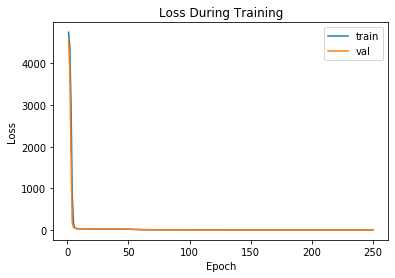

In [23]:
plot_model_history(history)

### Prediction and Plot

Forecast: [[67.56274  65.08459  62.96061  60.212303 57.51213  55.287636 54.975643
  58.445297 61.293873 62.69139  65.131744 66.67646 ]]


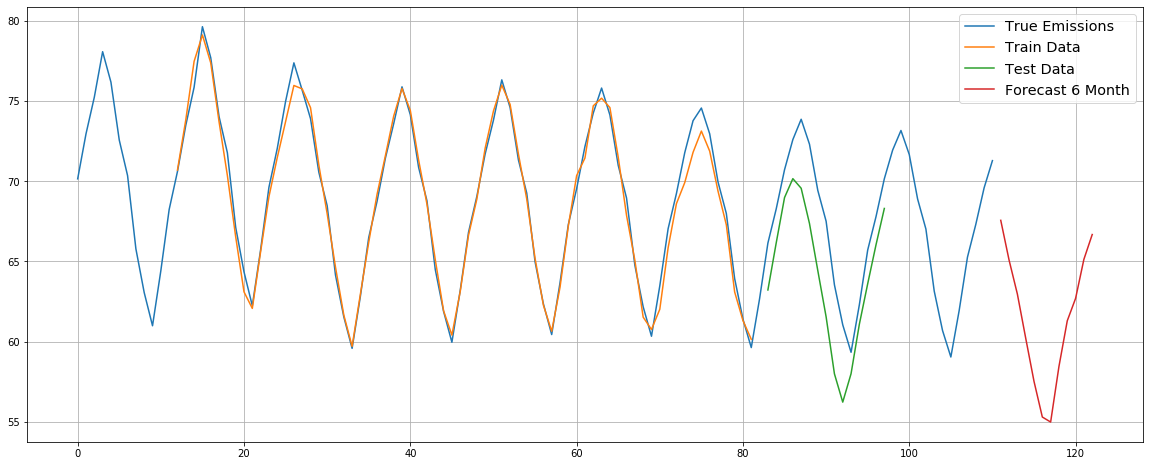

In [24]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan

# Features
#X = np.zeros((1, look_back, feature_data.shape[1]))
X = np.zeros((1, look_back, trainX.shape[2]))
#X[0] = feature_data[len(feature_data)-look_back:, :]
X[0] = feature_data[len(feature_data)-look_back:, :trainX.shape[2]]
predict = model.predict(X)
forecastPlot[len(feature_data):len(feature_data)+horizon] = predict[:]

print(f"Forecast: {predict}")

# Plot baseline, training, test and forecast
plt.figure(figsize=(20,8))
line1 = plt.plot(emission_data[:], label='True Emissions')
line2 = plt.plot(trainPredictPlot[:], label='Train Data')
plt.plot(testPredictPlot[:], label='Test Data')
plt.plot(forecastPlot[:], label='Forecast 6 Month')
plt.legend(fontsize='x-large')
plt.grid()
plt.xticks()
plt.show()